In [1]:
# library imports
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from platform import python_version
print(python_version())

3.8.8


# The DARPA OpTC dataset

The DARPA OpTC dataset contains events from an isolated enterprise network of 1000 host computers. Sensors logged `action` events associated with 11 `object` types over 14 days. On 3 consecutive days, a ‘red team’ introduced malware and malicious activity on 29 computers **(1)**.

The dataset is hosted on a Google drive **(2)** and documentation is available in a Github repository **(2)**. A ground truth document **(4)** provides details of the malicious events. Note that we define a malicious process to be a process which is linked to a malicious event detailed in the ground truth **(4)**. The starting point for the project was the raw json data **(3)**, ground truth table **(4)** and a table of `process.create` event data (extracted from `properties` in the raw json `PROCESS_CREATE_` events).

The DARPA OpTC dataset has over 17 billion events: significant data engineering is required to create the feature vectors for the Machine Learning (ML) experiments. 

We will establish a simple and interpretable baseline for the classification of computer process activity in the DARPA OpTC dataset. For each process, we will aggregate counts for the observed set of `(object, action)` events. Feature vectors for Machine Learning (ML) will be created by joining the frequency counts with ‘ground truth’ labels. 

## Extract Transform Load (ETL) data engineering pipeline for Machine Learning (ML) data

The raw json data was downloaded to AWS S3 and partitioned into 4554 part files, each o(500MB).

In the first ETL stage, we selected the data for the 29 computers attacked on the 3 ‘red team’ days, dropping detailed meta-data contained in `properties` tables **(1, 2, 4)**. The resulting 228 ‘summary’ files, each o(400MB), contained the following fields:

- `object` – one of `{FILE, FLOW, HOST, MODULE, PROCESS, REGISTRY, SERVICE, SHELL, TASK, THREAD, USER_SESSION}`

- `action` – one of a limited set associated with a given object: see Figure 1 below for types

- `actorID` – the unique identifier (UID) for the parent process

- `objectID` – the unique identifier (UID) for the object (child process if `object` = `PROCESS`)

- `hostname` – the name of the computer (eg. `SysClient0501.systemia.com`)

In the next stage, we created aggregate counts for every object.action pair observed for each `actorID`. The resulting 212 ‘aggregate’ files, each o(400KB), contained following additional field:

- `object.action counts` – dictionary of counts for the observed object.action pairs
 
In the final ETL stage, we join reference data from the ground truth table **(4, 5)** and the ‘process create’ table to the ‘aggregate’ data to create a dataframe of feature vectors for Machine Learning (ML). The resulting ML dataframe has shape (349841, 37). The first 4 columns in the ML dataframe are

- `actorID` – the unique identifier (UID) for the parent process

- `hostname` – the name of the computer (eg. `SysClient0501.systemia.com`)

- `process_name` – the name of the executable (eg. `Powershell.exe`)

- `label` – `0` for benign and `1` for malicious. 

The remaining 33 columns contain the `object.action` counts for `actorID`. 

## REFERENCES

**(1)** Md. Monowar Anjum, Shahrear Iqbal and Benoit Hamelin. 2021. _Analysing the Usefulness of the DARPA OpTC Dataset in Cyber Threat Detection Research._ **arXiv:2103.03080v3**. Retrieved from https://arxiv.org/abs/2103.03080 
Accepted for _ACM Symposium on Access Control Models and Technologies (SACMAT),_ 16-18 June, 2021, Barcelona, Spain (virtual event). ACM Inc., New York, NY. **DOI:** https://doi.org/10.1145/3450569.3463573

**(2)** DARPA. 2020. _Operationally Transparent Cyber (OpTC) Data Release. README._ Retrieved from http://github.com/FiveDirections/OpTC-data

**(3)** DARPA. 2020. _Operationally Transparent Cyber (OpTC) Data Release._ Retrieved from https://drive.google.com/drive/u/0/folders/1n3kkS3KR31KUegn42yk3-e6JkZvf0Caa

**(4)** DARPA. 2020. _OpTC Red Team Ground Truth._ Retrieved April 7, 2021 from https://github.com/FiveDirections/OpTC-data/blob/master/OpTCRedTeamGroundTruth.pdf

**(5)** `labels.csv` retrieved from (need approval)

In [3]:
datafile = "/Users/andrewveal/Downloads/darpa_data_revised.csv"
dftest = pd.read_csv(datafile, index_col=0)
print(dftest.shape)
print(dftest.iloc[0])

(349841, 37)
actorID                      0000085b-2ca5-462c-9f8e-42c2a33b2f5f
hostname                               SysClient0771.systemia.com
process_name                                          conhost.exe
label                                                           0
FILE_CREATE_                                                    0
FILE_DELETE_                                                    0
FILE_MODIFY_                                                    0
FILE_READ_                                                      0
FILE_RENAME_                                                    0
FILE_WRITE_                                                     0
FLOW_MESSAGE_                                                   0
FLOW_OPEN_                                                      0
FLOW_START_                                                     0
HOST_START_                                                     0
MODULE_LOAD_                                                   

## Check actorID is unique

In [4]:
Counter(dftest['actorID'].value_counts())

Counter({1: 349841})

## Class imbalance

Only 0.0016% of the *events* in the complete dataset **(1)** are malicious, so it is marginal whether there are sufficient examples for supervised learning.

We deine a *malicious process* as a process that is linked to a *malicious event* in the ground truth- that does NOT mean all events associated with a *malicious process* are malicious!

Let's get the class imbalance in our dataframe.

In [5]:
print(dftest['label'].value_counts())
total = dftest.shape[0]
total0 = dftest['label'].value_counts()[0]
total1 = dftest['label'].value_counts()[1]
print("probBenign: ", float(total0)/total, ", probMalicious: ", float(total1)/total)

0    348868
1       973
Name: label, dtype: int64
probBenign:  0.9972187365117297 , probMalicious:  0.002781263488270386


## Distribution of event types in the dataframe - careful interpretting it 

Remember the class imbalance when interpretting this figure

The fraction of event types for benign and malicious processes in the Machine Learning (ML) dataframe.

<ipython-input-6-364c2bb98639>:45: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(feature_list, Rotation = 'vertical')


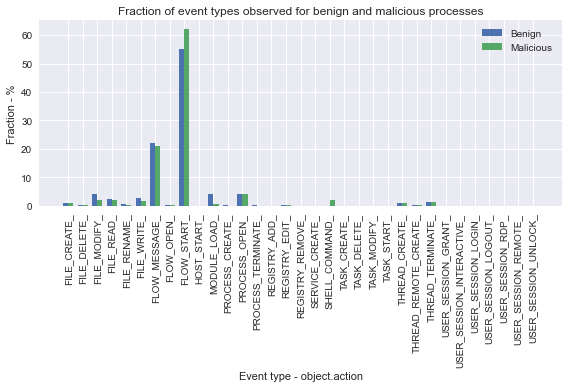

In [6]:
# Overall frequency of (object.action) pairs
X = dftest.iloc[:, 4:]
feature_list = list(X.columns)
frequencies = X.sum(axis=0)

X0 = dftest[dftest['label'] == 0].iloc[:, 4:]
X1 = dftest[dftest['label'] == 1].iloc[:, 4:]

frequencies0 = X0.sum(axis=0)
frequencies1 = X1.sum(axis=0)

total0 = frequencies0.sum()
total1 = frequencies1.sum()

fraction0 = (frequencies0 * 100.0) / total0
fraction1 = (frequencies1 * 100.0) / total1

total1

%matplotlib inline
# Set the style
plt.style.use('seaborn')

# Make a bar chart
#plt.bar(x_values, fraction1, orientation = 'vertical')
# Tick labels for x axis
#plt.xticks(x_values, feature_list, rotation='vertical')

# labels - feature_list
# fraction0 - benign
# fraction1 - malicious

x_values = np.arange(len(fraction1))  # list of label locations for plotting
width = 0.35                            # width of the bars

fig, ax = plt.subplots()
rects0 = ax.bar(x_values - width/2, fraction0, width, label='Benign')
rects1 = ax.bar(x_values + width/2, fraction1, width, label='Malicious')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fraction - %')
ax.set_xlabel('Event type - object.action')
ax.set_title('Fraction of event types observed for benign and malicious processes')
ax.set_xticks(x_values)
ax.set_xticklabels(feature_list, Rotation = 'vertical')
ax.legend()

fig.tight_layout()

plt.show()


# Baseline model - Random Forest 

> "The results are not bad when you consider the enormity of the swindle which I have perpetrated!"
Lars Onsager Biographical Memoirs of Fellows of the Royal Society 24 443

## Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (2nd Edition)

Superb practical book on Machine Learning with Scikit_Learn **(6)**

https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/

There is a github repo for the book:

https://github.com/ageron

https://github.com/ageron/handson-ml2

There are Jupyter notebooks for each chapter of the book - I have used some as starter code (Precision - Recall curves)

https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb

## Machine Learning with Python Cookbook

Another practical book with code examples **(7)**

https://www.oreilly.com/library/view/machine-learning-with/9781491989371/


## Scikit-Learn RandomForestClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Parameters that are set for RandomForestClassifier (7 - 14.4 Training a Random Forest Classifier)

- `random_state = 42` -> (because we like _Hitch Hikers Guide to the Galaxy_)

- `class_weight = 'balanced'` -> mitigates the class imbalance **(7)** (**14.8** Handling Imbalanced Classes)

- `oob_score = 'True'` -> gives you Out Of Bag score **(7)** (**14.11** Evaluating Random Forests with Out-of-Bag Errors)

- `n_estimators = default` (100) -> will do hyper parameter tuning later (and decide to leave at default)

- `n_jobs=-1` -> use all cores **(7)** ( )

## Scikit-Learn Train, Test Split - initial naive stratifed sampling approach

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

IMPORTANT - parameters for train_test_split:

- `stratify=y` -> maintain proportion of class labels in train and test

- `test_size= 0.3` -> old fashioned 70:30 split for small data: review this

- `random_state=42` -> (Hitch Hiker ...)

COMMENT - we will own up to the 'swindle' in good time - how have we split into train / test: random stratified


## METRICS

**Accuracy** - optimised by Random Forest - but cost weighting and stratification help mitigate class imbalance

**Confusion matrix** - TN, FP, FN, TP - can work out most of required metrics from these

Should consider visualization using scikit-learn functions

**Precison, Recall, F1 score** - our key metrics - we will optimize using **F1 score** **(8)** Andrew Ng says have ONE score for optimization

**Out of Bag estimate for accuracy** - a good estimate of cross-validation score

## REFERENCES

**(6)** Aurelien Geron. 2019. Geron. _Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems_ O'Reilly Media, Inc. CA

**(7)** Chris Albon. 2018. _Machine Learning with Python Cookbook: Practical Solutions from Preprocessing to Deep Learning_ O'Reilly Media, Inc. CA

**(8)** Andrew Ng. 2018. _Machine Learning Yearning: Technical Strategy for AI Engineers, In the Era of Deep Learning. Draft Version._ Retrieved May 6, 2021 from https://www.deeplearning.ai/programs/

Training results:
TN:  242212 , FP:  1995 , FN:  40 , TP:  641
accuracy:  0.9916900787298684
precision:  0.24317147192716237
recall:  0.9412628487518355
F1 score:  0.38649381971661134
log loss:  0.287021026593858

Out of bag estimate - validation
out of bag (accuracy) score:  0.9908284603573879

Test results:
TN:  103773 , FP:  888 , FN:  129 , TP:  163
accuracy:  0.9903099482625556
precision:  0.15509039010466222
recall:  0.5582191780821918
F1 score:  0.24274013402829486
log loss:  0.33468929555269766




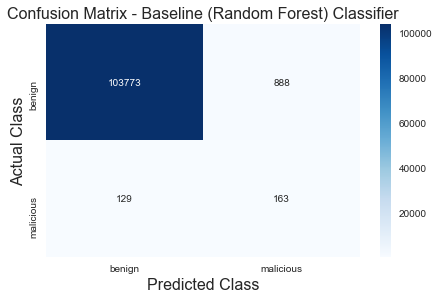

In [7]:
### Baseline model - Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss

X = dftest.iloc[:, 4:]
y = list(dftest['label'].values)   # may be better to keep dataframe - can always use dftest['label']

# train, test split - stratified

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced', oob_score=True, n_jobs=-1)

clf.fit(X_train, y_train)

y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# replace the home brew with sklearn methods

print("Training results:")

tn, fp, fn, tp =  confusion_matrix(y_train, y_train_predict).ravel()
print("TN: ", tn, ", FP: ", fp, ", FN: ", fn, ", TP: ", tp)

print("accuracy: ", accuracy_score(y_train, y_train_predict))
print("precision: ", precision_score(y_train, y_train_predict))
print("recall: ", recall_score(y_train, y_train_predict))
print("F1 score: ", f1_score(y_train, y_train_predict))
print("log loss: ", log_loss(y_train, y_train_predict))

print("\nOut of bag estimate - validation")
print("out of bag (accuracy) score: ", clf.oob_score_)

print("\nTest results:")

tn, fp, fn, tp =  confusion_matrix(y_test, y_test_predict).ravel()
print("TN: ", tn, ", FP: ", fp, ", FN: ", fn, ", TP: ", tp)

print("accuracy: ", accuracy_score(y_test, y_test_predict))
print("precision: ", precision_score(y_test, y_test_predict))
print("recall: ", recall_score(y_test, y_test_predict))
print("F1 score: ", f1_score(y_test, y_test_predict))
print("log loss: ", log_loss(y_test, y_test_predict))

# create confusion matrix 
matrix = confusion_matrix(y_test, y_test_predict)

# Create list of target class names - benign (0), malicious (1)

class_names = ['benign', 'malicious']

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

# Create heatmap - note that there is an error in the code in the O'Reilly book ...

print("\n")

%matplotlib inline
# Set the style
sns.heatmap(dataframe, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Baseline (Random Forest) Classifier", fontsize=16)
plt.tight_layout()
plt.xlabel("Predicted Class", fontsize=16)
plt.ylabel("Actual Class", fontsize=16)
plt.show()

# Feature Importance and Feature Selection for Random Forest

## Important - explanatory aspect of Random Forest is critical for cybersecurity

## Machine Learning with Python Cookbook¶

I've used code from _Machine Learning with Python Cookbook_ **(7)** - I am a nerd and have it on my smartphone Kindle app ...

**14.6** _Identifying Important Features in Random Forests_ has useful starter code

https://www.oreilly.com/library/view/machine-learning-with/9781491989371/

https://learning.oreilly.com/library/view/machine-learning-with/9781491989371/ch14.html#trees-and-forests

## Feature Selection choices

Take top-20 features for some future experiments?

Makes sense if you look at the figure below - and SHELL_COMMAND_ is ranked 19 :-)

Why did Turing / Oxford **(9)** pick 20 features?

Probably because there are 20 in the labels.csv Ground Truth (they don't say why?)

## REFERENCES

**(9)** Thomas Cochrane, Peter Foster, Varun Chhabra, Maud Lemercier, Terry Lyons and Cristopher Salvi. 2021. _SK-Tree: a systematic malware detection algorithm on streaming trees via the signature kernel._ **arXiv:2102.07904v3**. Retrieved from https://arxiv.org/abs/2102.07904

Variable: FILE_READ_                Importance: 0.25225293
Variable: MODULE_LOAD_              Importance: 0.14951012
Variable: THREAD_TERMINATE_         Importance: 0.14697375
Variable: PROCESS_OPEN_             Importance: 0.11248897
Variable: THREAD_CREATE_            Importance: 0.11127335
Variable: FLOW_START_               Importance: 0.06017053
Variable: PROCESS_TERMINATE_        Importance: 0.04016487
Variable: PROCESS_CREATE_           Importance: 0.03255062
Variable: THREAD_REMOTE_CREATE_     Importance: 0.02208227
Variable: FILE_WRITE_               Importance: 0.01395609
Variable: REGISTRY_EDIT_            Importance: 0.01262171
Variable: FLOW_MESSAGE_             Importance: 0.00987113
Variable: FILE_CREATE_              Importance: 0.00858525
Variable: FILE_DELETE_              Importance: 0.00721826
Variable: FILE_MODIFY_              Importance: 0.00688008
Variable: REGISTRY_ADD_             Importance: 0.00424545
Variable: FLOW_OPEN_                Importance: 0.002513

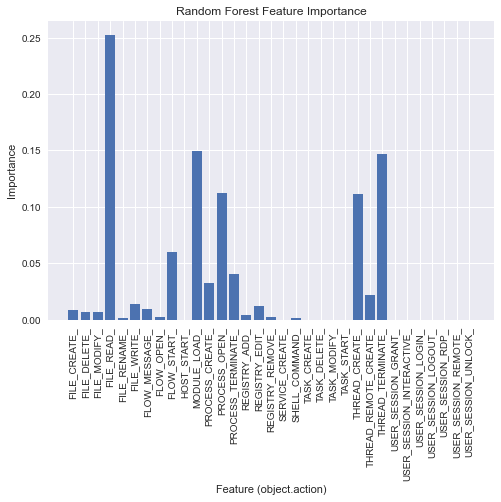

In [8]:
### Feature Importance

# Credit Towards Data Science Medium post and OReilly REF

# Random Forest feature importance - from cells above run CLF = RF ... maybe have optimized hyper-parameters

feature_list = list(X.columns)
importances = list(clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 8)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:25} Importance: {}'.format(*pair)) for pair in feature_importances];

# ********************* Figure showing feature importance *****************************

%matplotlib inline
# Set the style
plt.style.use('seaborn')
plt.tight_layout()
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Feature (object.action)'); plt.title('Random Forest Feature Importance');

# Random Forest Precision - Recall curve

StratifiedKFold(n_splits=5)

cross_val_predict -> setn_jobs=-1 (use all cores)

RandomForest has predict_proba

## Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition

https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/

Github repo

https://github.com/ageron/handson-ml

I've adapted code from this notebook:

https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb

In [9]:
# RF PR curve

# want cross_val_predict to be stratified version - does use stratified when set number - can pass in kfold

from sklearn.model_selection import cross_val_predict, StratifiedKFold

skfolds = StratifiedKFold(n_splits=5)  # no random shuffle as need to ensure cover all points for predict

# cv=5 - uses startifed by default
y_probas_forest = cross_val_predict(clf, X_train, y_train, cv=skfolds,
                                    method="predict_proba", n_jobs=-1)

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score, auc

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_forest)

AUCPR = auc(recalls, precisions)

# average_precision = average_precision_score(y_train, y_scores_forest)

threshold_value = 0.9146005509641874 # 0.7999789288419409 # RF setting *** MAX F1 score
recall_value_precision = recalls[np.argmax(precisions >= threshold_value)]

Max_F1_score = 2*(threshold_value*recall_value_precision)/(threshold_value+recall_value_precision)

print("threshold value for precision: ", threshold_value)
print("recall_value_threshold_precision: ", recall_value_precision)
print("max FI score: ", Max_F1_score)

threshold value for precision:  0.9146005509641874
recall_value_threshold_precision:  0.49045521292217326
max FI score:  0.6385093310761399


# Metrics - Precision, Recall and F1 score

In the figure below we highlight the point on the curve where the F1 score is maximized:

- Remember that our core hypothesis is that we can distinguish between malicious and benign processes using only the frequency count of the (object, action) events associated with each process as a feature vector.

- We can see that we can recover 50% of the malicious processes (Recall) and of those 50%, 90% are true positives (Precision) without any tuning of hyperparameters

- that suggests our hypothesis is reasonable

- we give the Area Under Curve (AUC) for the Precison Recall curve - it is a useful metric but should be handled with care

## AUROC considered harmful (David Hands keynote at KDD 2009 (Paris, France))

For imbalanced classes it is dubious to use the ROC curve and unforgiveable to use AUROC as a score, especially for optimization: I was at David Hand's KDD 2009 keynote and you could see demoralized graduate students after the talk ...

I've also heard him give the same message at a workshop at Imperial College many years later - why is this not widely known?!?

My Literature Review turned up papers using AUROC - the worst example is **(13)** which is supposed to be about tackling class imbalance.

Fun fact or urban myth - Dijkstra refused to take graduate students who had programmed in FORTAN because it had a goto statement (true or false)

## REFERENCES

**(10)** David J. Hand. 2009. _Mismatched Models, Wrong Results, and Dreadful Decisions._ Keynote at _15th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD),_ June, 2009 Paris, France recorded June 2009, published September 14, 2009 http://videolectures.net/kdd09_hand_mmwrdd/  (video) http://videolectures.net/site/normal_dl/tag=45840/kdd09_hand_mmwrdd_01.pdf (slides)

**(11)** David J. Hand. 2009. _Measuring classifier performance: a coherent alternative to the area under the ROC curve._ Mach Learn, **77** (2009), 103–123. **DOI:** https://doi.org/10.1007/s10994-009-5119-5

**(12)** Edsger Dijkstra (March 1968). _Go To Statement Considered Harmful._ Communications of the ACM. **11 (3):** 147–148. **DOI:** https://doi.org/10.1145/362929.362947. 

>"The unbridled use of the go to statement has as an immediate consequence that it becomes terribly hard to find a meaningful set of coordinates in which to describe the process progress. ... The go to statement as it stands is just too primitive, it is too much an invitation to make a mess of one's program."

**(13)** Charles Wheelus, Elias Bou-Harb and Xingquan Zhu. 2018. _Tackling Class Imbalance in Cyber Security Datasets._ In _Proceedings of the 2018 IEEE International Conference on Information Reuse and Integration (IRI),_ 6-9 July, 2018, Salt Lake City, UT, USA. IEEE Xplore, 229-232. https://doi.org/10.1109/IRI.2018.00041

<Figure size 576x396 with 0 Axes>

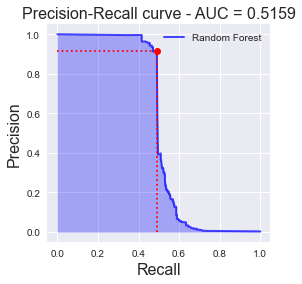

In [10]:
def plot_precision_vs_recall(precisions, recalls, clf, colour):
    plt.plot(recalls, precisions, color=colour, alpha=0.7, linewidth=2, label=clf)
    plt.fill_between(recalls, precisions, color=colour, alpha=0.3)
    plt.title("Precision-Recall curve - AUC = {0:0.4f}".format(AUCPR), fontsize=16)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.legend(loc="upper right")
    plt.axis([-0.05, 1.05, -0.05, 1.05])
    plt.grid(True)

%matplotlib inline
# Set the style
plt.style.use('seaborn')
plt.tight_layout()
plt.figure(figsize=(4, 4))
plot_precision_vs_recall(precisions, recalls, 'Random Forest', 'b')
plt.plot([recall_value_precision, recall_value_precision], [0., threshold_value], "r:")
plt.plot([0.0, recall_value_precision], [threshold_value, threshold_value], "r:")
plt.plot([recall_value_precision], [threshold_value], "ro")
plt.show()

# Useful explanatory plot adapted from Geron notebook

## Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition¶

https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/

Github repo

https://github.com/ageron/handson-ml

I've adapted code from this notebook:

https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb

## AUROC considered harmful

I thought you said AUROC was harmful? 

This is provided for information only as it is prevalent in the literature and may be the only way to compare your results with their results.

Shouldn't papers be rejected if they use AUROC for imbalanced class datasets?

<Figure size 576x396 with 0 Axes>

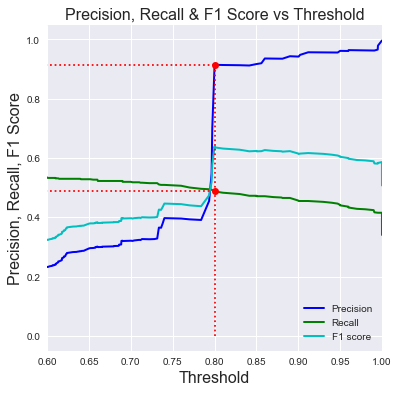

threshold_value_precision =  0.7999789288419409
AUROC:  0.8105640344464276


In [11]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.title("Precision, Recall & F1 Score vs Threshold", fontsize=16)
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    F1score = [2*(precision*recall)/(precision+recall) for precision, recall in zip(precisions, recalls)]
    plt.plot(thresholds, F1score[:-1], "c-", label="F1 score", linewidth=2)
    plt.legend(loc="lower right") # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.ylabel("Precision, Recall, F1 Score", fontsize=16)
    plt.grid(True)                              # Not shown
    plt.axis([0.6, 1.0, -0.05, 1.05])             # Not shown

recall_value_precision = recalls[np.argmax(precisions >= threshold_value)]
threshold_value_precision = thresholds[np.argmax(precisions >= threshold_value)]

%matplotlib inline
# Set the style
plt.style.use('seaborn')
plt.tight_layout()
plt.figure(figsize=(6, 6))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_value_precision, threshold_value_precision], [0., threshold_value], "r:")                 # Not shown
plt.plot([-0.05, threshold_value_precision], [threshold_value, threshold_value], "r:")                                # Not shown
plt.plot([-0.05, threshold_value_precision], [recall_value_precision, recall_value_precision], "r:")# Not shown
plt.plot([threshold_value_precision], [threshold_value], "ro")                                             # Not shown
plt.plot([threshold_value_precision], [recall_value_precision], "ro")                             # Not shown
plt.show()

print("threshold_value_precision = ", threshold_value_precision)
print("AUROC: ", roc_auc_score(y_train, y_scores_forest))

# Adjusting the threshold to maximize F1 score

## Resulting Precision and Recall

We waved hands a bit when we looked at the Figures above - what is the maxvalue of F1 and what are the Precision and Recall when you optimize the probability threshold?

This could be argued to be premature optimization - we haven't done any hyperparameter tuning.

Probably need to look at the code - make sure you get the right threshold value (think it is correct)

In [12]:
F1score = [2*(precision*recall)/(precision+recall) for precision, recall in zip(precisions, recalls)]

MaxF1Score = max(F1score)
index = np.argmax(F1score)

print("Maximum value of F1 score = ", MaxF1Score)
print("Precision with optimized probability threshold = ", precisions[index])
print("Recall with optimized probability threshold = ", recalls[index])

Maximum value of F1 score =  0.638623326959847
Precision with optimized probability threshold =  0.915068493150685
Recall with optimized probability threshold =  0.49045521292217326


In [13]:
threshold = threshold_value_precision  # threshold_value_precision

predicted_proba = clf.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

#prob_preds = clf.predict_proba(X)
#threshold = 0.11 # define threshold here
#preds = [1 if prob_preds[i][1]> threshold else 0 for i in range(len(prob_preds))]

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss

print("accuracy: ", accuracy_score(y_test, predicted))
print("precision: ", precision_score(y_test, predicted))
print("recall: ", recall_score(y_test, predicted))
print("F1 score: ", f1_score(y_test, predicted))
print("log loss: ", log_loss(y_test, predicted))

accuracy:  0.9984373957866854
precision:  0.8809523809523809
recall:  0.5068493150684932
F1 score:  0.6434782608695652
log loss:  0.05397058988989415


# Basic hyper parameter tuning for RandomForest

## n_estimators

Just use standard _stratfied_ cross validation with simple train/validation split

Validation curves for **n_estimators** hyper parameter first

Want to avoid over-fitting - listen to Andrew Ng!

## Machine Learning with Python Cookbook

**(7)** **11.3** _Visualizing the Effect of Hyperparameter Values_

https://www.oreilly.com/library/view/machine-learning-with/9781491989371/

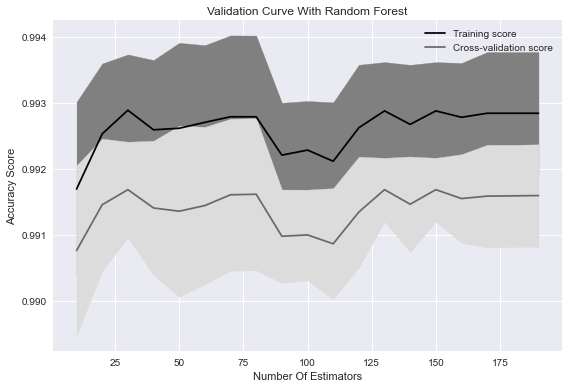

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X = dftest.iloc[:, 4:]
y = list(dftest['label'].values)   # may be better to keep dataframe - can always use dftest['label']

# train, test split - stratified - LOWER DOWN!

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=5)

clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced', oob_score=True, n_jobs=-1)

# Create range of values for parameter
param_range = np.arange(0, 200, 10)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(
    # Classifier
    clf,
    # Feature matrix
    X_train,
    # Target vector
    y_train,
    # Hyperparameter to examine
    param_name="n_estimators",
    # Range of hyperparameter's values
    param_range=param_range,
    # Number of folds or the KFold object
    cv=skfolds,
    # Performance metric
    scoring="accuracy",
    # Use all computer cores
    n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std,
                 train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std,
                 test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Estimators")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()



# Basic hyper parameter tuning for RandomForest

## max_depth

Just use standard _stratfied_ cross validation with simple train/validation split

Validation curves for **max_depth** hyper parameter second

This is the key hyperparameter to set if we want to avoid over-fitting to the training set

Want to avoid over-fitting - listen to Andrew Ng!

## Machine Learning with Python Cookbook

**(7)** **11.3** _Visualizing the Effect of Hyperparameter Values_

https://www.oreilly.com/library/view/machine-learning-with/9781491989371/

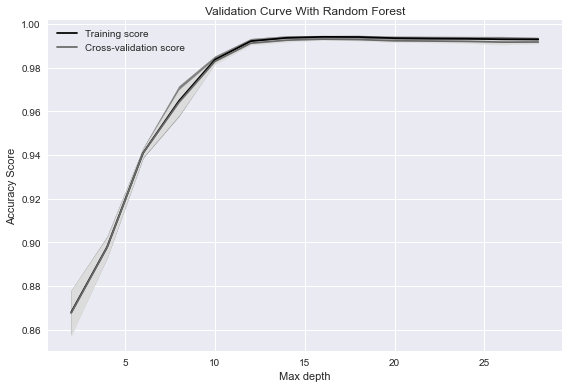

In [15]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=5)

clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced', oob_score=True, n_jobs=-1)

# Create range of values for parameter
param_range = np.arange(0, 30, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(
    # Classifier
    clf,
    # Feature matrix
    X_train,
    # Target vector
    y_train,
    # Hyperparameter to examine
    param_name="max_depth", #  "n_estimators",
    # Range of hyperparameter's values
    param_range=param_range,
    # Number of folds or the KFold object
    cv=skfolds,
    # Performance metric
    scoring="accuracy",
    # Use all computer cores
    n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std,
                 train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std,
                 test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Max depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()
